In [19]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,RSI,RSI_Strategy,Average_Price,Money_Flow,Pos_Flow,Neg_Flow,MFI,MFI_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
26,105.084999,106.430000,104.415001,104.599998,143017,68.965512,0.0,105.310000,1.506112e+07,105.310000,0.000000,61.502268,NaN,NaN,0,NaN,NaN
27,101.839996,105.089996,101.110001,105.084999,402875,63.626120,0.0,102.679998,4.136720e+07,0.000000,102.679998,57.051346,0.0,0.0,0,-0.030880,0.000000
28,96.820000,100.400002,96.436501,100.339996,112574,48.966428,0.0,97.885501,1.101936e+07,0.000000,97.885501,57.007008,0.0,0.0,0,-0.078651,0.000000
29,98.690002,99.199997,96.560600,96.690002,122237,48.727111,0.0,98.150200,1.199759e+07,98.150200,0.000000,56.990759,0.0,0.0,0,-0.060855,0.000000
30,95.889999,98.589996,95.660004,98.570000,94004,44.367620,0.0,96.713333,9.091440e+06,0.000000,96.713333,50.090866,0.0,0.0,0,-0.087501,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5081,532.000000,533.519775,530.683105,531.229980,56067,40.712693,0.0,532.067627,2.983144e+07,532.067627,0.000000,57.242310,0.0,0.0,0,4.062568,-0.022126
5082,531.405029,532.000000,530.433899,531.409973,37274,38.238611,0.0,531.279643,1.980292e+07,0.000000,531.279643,50.088327,0.0,0.0,0,4.056907,-0.022126
5083,525.799988,531.840088,525.799988,531.349976,62812,32.200400,0.0,527.813354,3.315301e+07,0.000000,527.813354,42.929933,0.0,0.0,0,4.003568,-0.022126
5084,527.140015,528.000000,525.109985,526.099976,100217,36.216528,0.0,526.750000,5.278930e+07,0.000000,526.750000,43.001763,0.0,0.0,0,4.016320,-0.022126


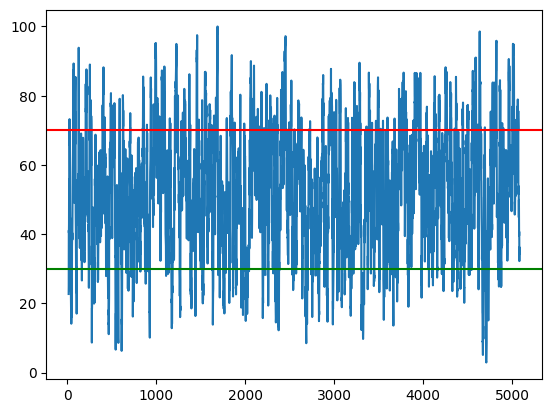

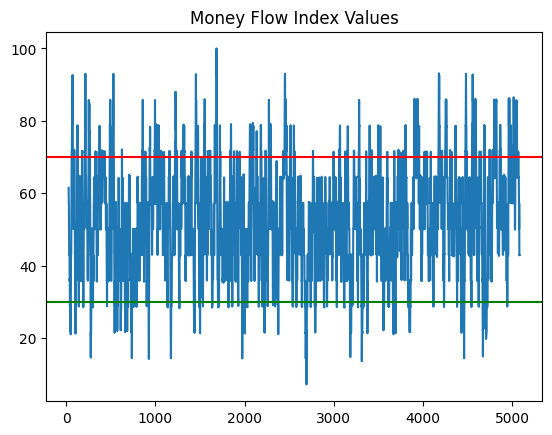

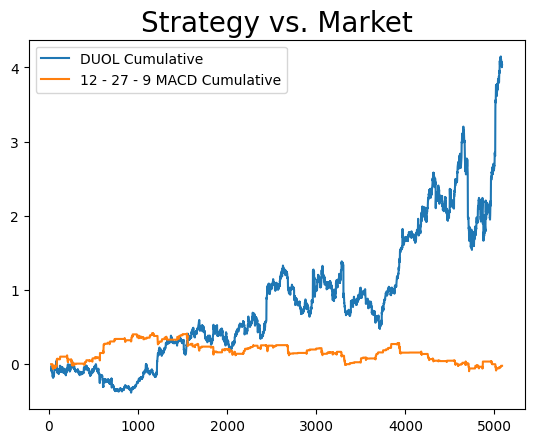

In [20]:
TICKER = 'DUOL'
INTERVAL='1h'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

RSI_LENGTH = 14
MFI_LENGTH = 14
MFI_OVERBOUGHT = 70
MFI_OVERSOLD = 30
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')

    return df.dropna()

def add_RSI_strategy(df, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_MFI(df, length=MFI_LENGTH, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):

    df['Average_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Money_Flow'] = df['Volume'] * df['Average_Price']
 
    # initialize empty flows
    df['Pos_Flow'] = 0
    df['Neg_Flow'] = 0

    df['Pos_Flow'] = np.where(df['Average_Price'].diff() > 0, df['Average_Price'], 0)
    df['Neg_Flow'] = np.where(df['Average_Price'].diff() < 0, df['Average_Price'], 0)

    mfr = df['Pos_Flow'].rolling(length).sum() / df['Neg_Flow'].rolling(length).sum()

    # add money flow column
    df['MFI'] = 100 - (100 / (1 + mfr))

    plt.figure()
    plt.plot(df['MFI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Money Flow Index Values');
        
    return df.dropna()

def add_MFI_strategy(df, overbought=MFI_OVERBOUGHT, oversold=MFI_OVERSOLD):

    df['MFI_Strategy'] = 0
    df['MFI_Strategy'] = np.where(df['MFI'] > overbought, -1, 
                     np.where(df['MFI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['MFI_Strategy'] = df['MFI_Strategy'].shift(1)
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['RSI_Strategy'] + df['MFI_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 1, 
                     np.where(df['Full_Strategy'] == -2, -1, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_RSI(df)
    df = add_RSI_strategy(df)
    df = add_MFI(df)
    df = add_MFI_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()

df